In [199]:
#Declaring imports
import csv
import os
import pandas as pd
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgd



In [200]:
DEBUGGING = False

In [201]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'

In [202]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)


In [203]:
if DEBUGGING:
    partition = 0.9 * train_df.shape[0]
    test_df = train_df.loc[partition:,]
    train_df = train_df.loc[:partition,]
    

# Exploratory Data Analysis

In [204]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [178]:
#putting each col into a bucket
discrete = []
continuous = []
for col in train_df.columns:
    length = len(train_df[col].unique())
    if length <= 25 :
        discrete.append(col)
    else:
        continuous.append(col)
        

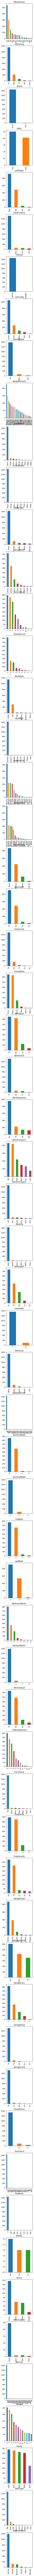

In [179]:
#Seeing the distribution of discrete data

fig, axes = plt.subplots(nrows=len(discrete), ncols=1, figsize=(3,5*len(discrete)))
for i, col_name in enumerate(discrete):
    train_df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)


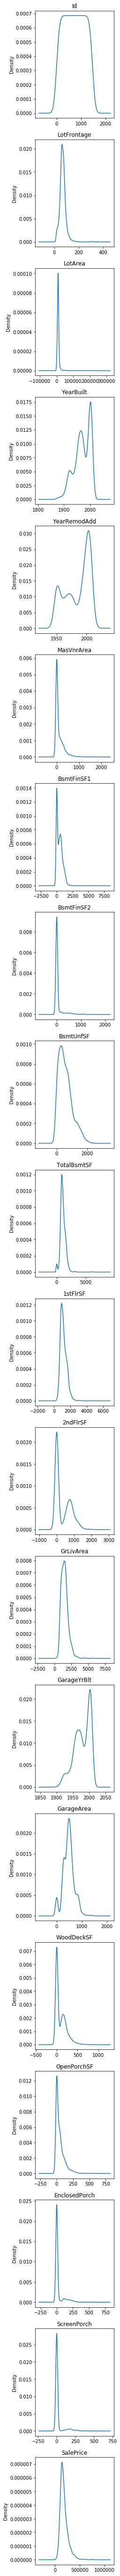

In [180]:
#Distributions of continuous data
fig, axes = plt.subplots(nrows=len(continuous), ncols=1, figsize=(3,5*len(continuous)))
for i, col_name in enumerate(continuous):
    try:
        train_df[col_name].plot(kind='density', ax=axes[i], title = col_name)
    except:
        print("failed: " + col_name)


In [209]:
#Finding number of null values
def count_nulls(train_df, test_df):
    results = {}
    vals = {}
    for key in train_df.keys():
        count = train_df[key].isnull().sum()
        if count > 0:
            vals[key] = count
    results['train'] = vals

    vals = {}
    for key in test_df.keys():
        count = test_df[key].isnull().sum()
        if count > 0:
            vals[key] = count
    results['test'] = vals
    
    return pd.DataFrame.from_dict(results, dtype=int)

count_nulls(train_df, test_df)

,train,test
Electrical,1.0,NaN
Exterior1st,NaN,1.0
Exterior2nd,NaN,1.0
Functional,NaN,2.0
KitchenQual,NaN,1.0
LotFrontage,259.0,227.0
MSZoning,NaN,4.0
SaleType,NaN,1.0
Utilities,NaN,2.0


In [208]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [207]:
def replace_na(cols, val):
    for df in [train_df, test_df]:
        if type(cols) == list:
            for col in cols:
                df.loc[:, col] = df.loc[:, col].fillna(val)
        else:
            df.loc[:, cols] = df.loc[:, cols].fillna(val)

#Some NaNs indicate the absence of a feature (Indicated from data sheet)
replace_na(["Alley", "MiscFeature", "PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     "MasVnrType", 'MSSubClass'], "None")

#Some NaNs indicate that there are 0 values
replace_na(['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                      'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"], "None")


In [210]:
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [211]:
train_df['MSZoning'] = train_df['MSZoning'].fillna(train_df['MSZoning'].mode()[0])
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])

In [212]:
train_df.drop(['Utilities'], inplace = True, axis = 1)
test_df.drop(['Utilities'], inplace = True, axis = 1)

In [187]:
replace_na("Functional", "Typ")

In [213]:
def replace_na_with_most_frequent(col):

    most = train_df.append(test_df)[col].mode()[0]
    replace_na(col, most)

In [189]:
replace_na_with_most_frequent("KitchenQual")
replace_na_with_most_frequent("Exterior1st")
replace_na_with_most_frequent("Exterior2nd")
replace_na_with_most_frequent("SaleType")
replace_na_with_most_frequent("SaleType")
replace_na_with_most_frequent("Electrical")


/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


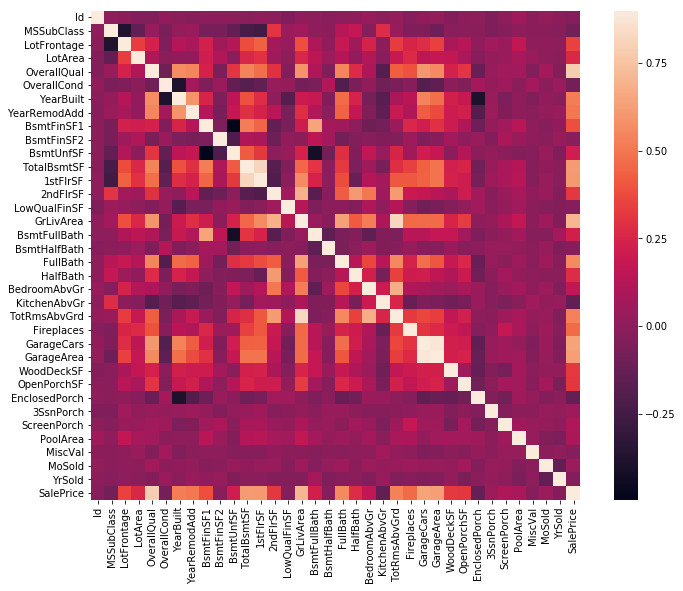

In [214]:
corrmat = train_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#Things that I should consider doing:
1) Remove outliers from data
2) Start applying regression techniques

In [215]:
all_data = pd.get_dummies(train_df.append(test_df))
print(train_df.shape)
print(test_df.shape)


(1460, 80)
(1459, 79)


/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [192]:
train_df = all_data[:1460]
test_df = all_data[1460:]

In [196]:
train_df.Fireplaces

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'GrLivArea', 'HalfBath', 'Id',
       ...
       'TotalBsmtSF_2633', 'TotalBsmtSF_2660.0', 'TotalBsmtSF_2846.0',
       'TotalBsmtSF_3094', 'TotalBsmtSF_3138', 'TotalBsmtSF_3200',
       'TotalBsmtSF_3206', 'TotalBsmtSF_5095.0', 'TotalBsmtSF_6110',
       'TotalBsmtSF_None'],
      dtype='object', length=4921)

In [193]:
#MSSubClass=The building class
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
train_df['OverallCond'] = train_df['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
train_df['YrSold'] = train_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train_df[c].values)) 
    train_df[c] = lbl.transform(list(train_df[c].values))

# shape        
print('Shape train_df: {}'.format(train_df.shape))

/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

KeyError: 'FireplaceQu'

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df.SalePrice.values

In [ ]:
#TODO: Try with shuffle for CV
n_folds = 5
def rmse(model):
    return cross_val_score(model, x_train, y_train, cv=5)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))

In [ ]:
rmse(lasso)

In [ ]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = Lasso(alpha =0.0005, random_state=1)
rmsle_cv(lasso)

In [ ]:
for c in x_train.columns:
    try:
        if True in x_train[c].str.contains('WD').values:
            print(c)
    except:
        print("Can't" + c)

In [ ]:
True in x_train['Electrical'].str.contains('Normal').values

In [ ]:
x_train.LotFrontage;